<a href="https://colab.research.google.com/github/GressJess/4179courseproject/blob/main/CatDogEvaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install albumentations==0.4.6

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import torch
import os
import sys
from PIL import Image

from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2


# Utils

In [4]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:

#MONET = Cat and PHOTO = dog
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project"
VAL_DIR = "/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 10
LOAD_MODEL = True
SAVE_MODEL = True
SAVEDMODELFOLDER = "/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project/Code/SavedModels/Cats"
CHECKPOINT_GEN_P = SAVEDMODELFOLDER +  "/genphoto.pth.tar"
CHECKPOINT_GEN_M = SAVEDMODELFOLDER +"/genmonet.pth.tar"
CHECKPOINT_CRITIC_P = SAVEDMODELFOLDER + "/criticphoto.pth.tar"
CHECKPOINT_CRITIC_M = SAVEDMODELFOLDER + "/criticmonet.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
     ],
    additional_targets={"image0": "image"},
)

#Dataset 

In [6]:

class MonetPhotoDataset(Dataset):
    def __init__(self, root_monet, root_photo, transform=None):
        self.root_monet = root_monet
        self.root_photo = root_photo
        self.transform = transform

        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)
        self.length_dataset = min(len(self.monet_images), len(self.photo_images)) # 1000, 1500
        self.monet_len = len(self.monet_images)
        self.photo_len = len(self.photo_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        monet_img = self.monet_images[index % self.monet_len]
        photo_img = self.photo_images[index % self.photo_len]

        monet_path = os.path.join(self.root_monet, monet_img)
        photo_path = os.path.join(self.root_photo, photo_img)

        monet_img = np.array(Image.open(monet_path).convert("RGB"))
        photo_img = np.array(Image.open(photo_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=monet_img, image0=photo_img)
            monet_img = augmentations["image"]
            photo_img = augmentations["image0"]

        return monet_img, photo_img


In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [8]:


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


In [9]:

def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)

test()


torch.Size([5, 1, 30, 30])


# Generator

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)


In [11]:

class NonResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.block(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


In [12]:

class Generator(nn.Module):
    def __init__(self, img_channels, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[NonResidualBlock(num_features*4) for _ in range(num_residuals//2)],
            *[ResidualBlock(num_features*4) for _ in range(num_residuals//2)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


tensor([[[-0.1274, -0.4407, -0.4640,  ...,  0.0669, -0.3191, -0.2484],
         [-0.0056, -0.2018,  0.2408,  ..., -0.2305,  0.4361, -0.0829],
         [-0.0970, -0.1693, -0.1539,  ..., -0.2688, -0.2698, -0.2104],
         ...,
         [ 0.1931, -0.2765,  0.3350,  ..., -0.3256, -0.1154, -0.1911],
         [-0.4574, -0.4279,  0.0713,  ..., -0.2735,  0.0859, -0.1889],
         [-0.0274, -0.0313, -0.2667,  ...,  0.0871, -0.1817, -0.2128]],

        [[-0.2832,  0.2848, -0.0813,  ..., -0.2309,  0.1345,  0.0450],
         [ 0.0219, -0.1325, -0.2243,  ..., -0.3496,  0.4068,  0.3233],
         [-0.0577,  0.2063, -0.0909,  ...,  0.1608,  0.1076, -0.3579],
         ...,
         [-0.3404, -0.2663,  0.2884,  ..., -0.1673,  0.2665, -0.0456],
         [-0.1266, -0.3247, -0.0835,  ..., -0.4164, -0.1625, -0.1046],
         [ 0.4768, -0.3098,  0.0624,  ..., -0.1752,  0.3031, -0.2029]],

        [[ 0.1303,  0.1202,  0.2121,  ...,  0.1236, -0.2870,  0.1916],
         [ 0.0525,  0.0041, -0.2204,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


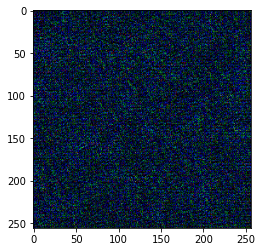

In [13]:

def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x)[0])
    img = gen(x)[0].detach().numpy()
    img = np.moveaxis(img,0,2)

    plt.imshow(img)
    #plt.imshow(gen(x)[0])

if __name__ == "__main__":
    test()


# Training 

In [14]:
def train_fn(disc_P, disc_M, gen_M, gen_P, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler):
    P_reals = 0
    P_fakes = 0
    saved = 0
    loop = tqdm(loader, leave=True)

    for idx, (monet, photo) in enumerate(loop):
        monet = monet.to(DEVICE)
        photo = photo.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_photo = gen_P(monet)
            D_P_real = disc_P(photo)
            D_P_fake = disc_P(fake_photo.detach())
            P_reals += D_P_real.mean().item()
            P_fakes += D_P_fake.mean().item()
            D_P_real_loss = mse(D_P_real, torch.ones_like(D_P_real))
            D_P_fake_loss = mse(D_P_fake, torch.zeros_like(D_P_fake))
            D_P_loss = D_P_real_loss + D_P_fake_loss

            fake_monet = gen_M(photo)
            D_M_real = disc_M(monet)
            D_M_fake = disc_M(fake_monet.detach())
            D_M_real_loss = mse(D_M_real, torch.ones_like(D_M_real))
            D_M_fake_loss = mse(D_M_fake, torch.zeros_like(D_M_fake))
            D_M_loss = D_M_real_loss + D_M_fake_loss

            # put it togethor
            D_loss = (D_P_loss + D_M_loss)/2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_P_fake = disc_P(fake_photo)
            D_M_fake = disc_M(fake_monet)
            loss_G_P = mse(D_P_fake, torch.ones_like(D_P_fake))
            loss_G_M = mse(D_M_fake, torch.ones_like(D_M_fake))

            # cycle loss
            cycle_monet = gen_M(fake_photo)
            cycle_photo = gen_P(fake_monet)
            cycle_monet_loss = l1(monet, cycle_monet)
            cycle_photo_loss = l1(photo, cycle_photo)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            # identity_monet = gen_M(monet)
            # identity_photo = gen_P(photo)
            # identity_monet_loss = l1(monet, identity_monet)
            # identity_photo_loss = l1(photo, identity_photo)

            # add all togethor
            G_loss = (
                loss_G_M
                + loss_G_P
                + cycle_monet_loss * LAMBDA_CYCLE
                + cycle_photo_loss * LAMBDA_CYCLE
                # + identity_photo_loss * LAMBDA_IDENTITY
                # + identity_monet_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_photo*0.5+0.5, f"/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project/CDgenerated/fake_dog{saved}.png")
            save_image(monet*0.5+0.5, f"/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project/CDgenerated/fake_dogbefore{saved}.png")
            save_image(fake_monet*0.5+0.5, f"/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project/CDgenerated/fake_cat{saved}.png")
            save_image(photo*0.5+0.5, f"/content/drive/MyDrive/Colab Notebooks/Courseproject/4179 Course Project/CDgenerated/fake_catbefore{saved}.png")

            if SAVE_MODEL:
                save_checkpoint(gen_P, opt_gen, filename=CHECKPOINT_GEN_P)
                save_checkpoint(gen_M, opt_gen, filename=CHECKPOINT_GEN_M)
                save_checkpoint(disc_P, opt_disc, filename=CHECKPOINT_CRITIC_P)
                save_checkpoint(disc_M, opt_disc, filename=CHECKPOINT_CRITIC_M)
                
            saved +=1
        loop.set_postfix(P_real=P_reals/(idx+1), P_fake=P_fakes/(idx+1))



In [15]:
def training():
    disc_P = Discriminator(in_channels=3).to(DEVICE)
    disc_M = Discriminator(in_channels=3).to(DEVICE)
    gen_M = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_P = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_P.parameters()) + list(disc_M.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_M.parameters()) + list(gen_P.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_P, gen_P, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_M, gen_M, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_P, disc_P, opt_disc, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_M, disc_M, opt_disc, LEARNING_RATE,
        )

    dataset = MonetPhotoDataset(
        root_photo=TRAIN_DIR+"/catdogfolder/PetImages/Dog", root_monet=TRAIN_DIR+"/catdogfolder/PetImages/Cat", transform=transforms
    )
    val_dataset = MonetPhotoDataset(
       root_photo=TRAIN_DIR+"/catdogfolder/PetImages/Dog", root_monet=TRAIN_DIR+"/catdogfolder/PetImages/Cat", transform=transforms
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(disc_P, disc_M, gen_M, gen_P, loader, opt_disc, opt_gen, L1, mse, d_scaler, g_scaler)
        if SAVE_MODEL:
            save_checkpoint(gen_P, opt_gen, filename=CHECKPOINT_GEN_P)
            save_checkpoint(gen_M, opt_gen, filename=CHECKPOINT_GEN_M)
            save_checkpoint(disc_P, opt_disc, filename=CHECKPOINT_CRITIC_P)
            save_checkpoint(disc_M, opt_disc, filename=CHECKPOINT_CRITIC_M)
        
    


In [16]:
training()

=> Loading checkpoint


RuntimeError: ignored

In [ ]:
load_checkpoint(
            CHECKPOINT_GEN_P, gen_P, opt_gen, LEARNING_RATE,
        )